In [1]:
from climada.entity import Exposures

In [67]:
import geopandas as gpd
import pandas as pd
sites = pd.read_excel("/Users/szelie/OneDrive - ETH Zurich/unesco/whc-sites-2021.xlsx")

In [68]:
crs = {'init': 'epsg:4326'}
sites = gpd.GeoDataFrame(
    sites, geometry=gpd.points_from_xy(sites.longitude, sites.latitude))

In [69]:
sites = sites[sites.category=='Cultural']

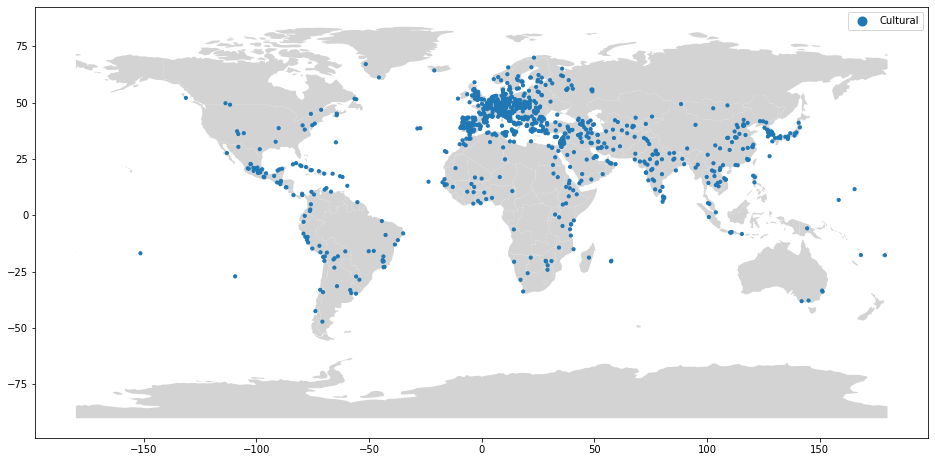

In [70]:
import matplotlib.pyplot as plt
fig, axis = plt.subplots(figsize=(16, 12))
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.plot(color='lightgray', ax=axis)
sites.plot('category', ax=axis, categorical=True,
             markersize=10, legend=True)
fig.savefig('map_cutural_sites.pdf')

In [6]:
exposures = Exposures()
exposures.gdf = sites

In [7]:
from climada.util.api_client import Client

In [8]:
client = Client()

In [9]:
tc_present = client.get_hazard('tropical_cyclone', properties={'spatial_coverage':'global', 'climate_scenario':'historical'})

https://climada.ethz.ch/data-api/v1/dataset	climate_scenario=historical	data_type=tropical_cyclone	limit=100000	name=None	spatial_coverage=global	status=active	version=None


In [81]:
flood_present = client.get_hazard('river_flood', properties={'spatial_coverage':'global', 'climate_scenario':'historical'})

https://climada.ethz.ch/data-api/v1/dataset	climate_scenario=historical	data_type=river_flood	limit=100000	name=None	spatial_coverage=global	status=active	version=None


<GeoAxesSubplot:title={'center':'TC max intensity at each point'}>

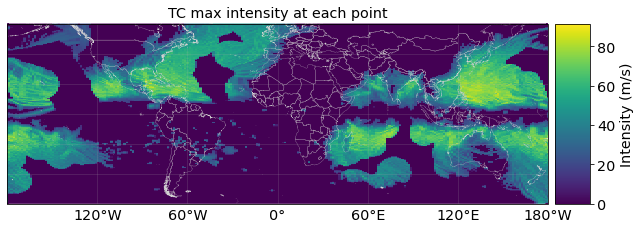

In [49]:
tc_present.plot_intensity(0)


In [10]:
hist_events = [event for event in tc_present.event_name if 'gen' not in event]

In [11]:
tc_hist = tc_present.select(event_names=hist_events)

In [12]:
from climada.entity import Exposures, ImpactFunc, ImpactFuncSet
import numpy as np
imp_fun_set = ImpactFuncSet()
imp_fun = ImpactFunc()
imp_fun.haz_type = 'TC'
imp_fun.id = 1
imp_fun.name = 'impf_TC'
# provide unit of the hazard intensity
imp_fun.intensity_unit = 'm/s'
# provide values for the hazard intensity, mdd, and paa
lin =  np.ones(57)
imp_fun.intensity = np.linspace(0, 100, num=100)
imp_fun.mdd = np.concatenate((np.zeros(43), lin))
imp_fun.paa = np.ones(len(imp_fun.mdd))
# check if the all the attributes are set correctly
imp_fun.check()
imp_fun_set.append(imp_fun)

In [79]:
imp_fun = ImpactFunc()
imp_fun.haz_type = 'RF'
imp_fun.id = 1
imp_fun.name = 'impf_RF'
# provide unit of the hazard intensity
imp_fun.intensity_unit = 'm/s'
# provide values for the hazard intensity, mdd, and paa
lin =  np.ones(9)
imp_fun.intensity = np.linspace(0, 10, num=10)
imp_fun.mdd = np.concatenate((np.zeros(1), lin))
imp_fun.paa = np.ones(len(imp_fun.mdd))
# check if the all the attributes are set correctly
imp_fun.check()
imp_fun_set.append(imp_fun)

exposures.gdf['impf_RF'] = 1



<AxesSubplot:title={'center':'TC 1: impf_TC'}, xlabel='Intensity (m/s)', ylabel='Impact (%)'>

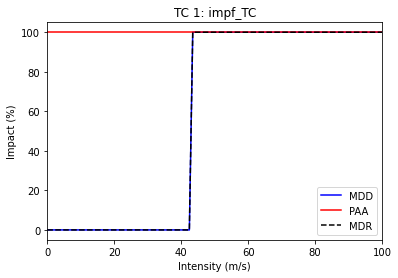

In [65]:
imp_fun.plot()

In [15]:
from climada.engine import Impact
impact_TC = Impact()
exposures.gdf['impf_TC'] = 1
exposures.gdf['value'] = 1
impact_TC.calc(exposures,imp_fun_set,tc_hist,save_mat=True)
    
    

2022-08-25 10:34:05,473 - climada.engine.impact - WARNING - The use of Impact().calc() is deprecated. Use ImpactCalc().impact() instead.
2022-08-25 10:34:08,753 - climada.util.coordinates - WARNING - Distance to closest centroid is greater than 100km for 93 coordinates.


In [14]:
impact_TC

NameError: name 'impact_TC' is not defined

In [110]:
from climada.engine import Impact
impact_flood = Impact()
exposures = Exposures()
exposures.gdf = sites
exposures.gdf['impf_RF'] = 1
exposures.gdf['value'] = 1
impact_flood.calc(exposures,imp_fun_set,flood_present,save_mat=True)
    
    

2022-08-24 16:20:36,576 - climada.engine.impact - WARNING - The use of Impact().calc() is deprecated. Use ImpactCalc().impact() instead.


<GeoAxesSubplot:title={'center':'Expected annual impact'}>

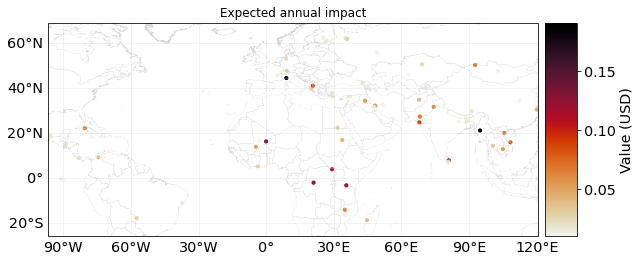

In [89]:
impact_flood.coord_exp = impact_flood.coord_exp[impact_flood.eai_exp>0.01]
impact_flood.eai_exp = impact_flood.eai_exp[impact_flood.eai_exp>0.01]


impact_flood.plot_scatter_eai_exposure(s=10, pop_name=False)

In [36]:
#impact_gdf_flood = impact_flood._build_exp().gdf
#impact_gdf_flood['impact ratio'] = impact_gdf_flood['value']

impact_gdf_tc = impact_TC._build_exp().gdf
impact_gdf_tc['impact ratio'] = impact_gdf_tc['value']

<GeoAxesSubplot:title={'center':'Expected annual impact'}>

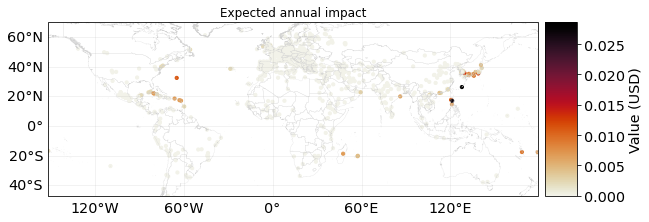

In [177]:
#impact_TC.coord_exp = impact_TC.coord_exp[impact_TC.eai_exp>0.01]
#impact_TC.eai_exp = impact_TC.eai_exp[impact_TC.eai_exp>0.01]



impact_TC.plot_scatter_eai_exposure(s=10, pop_name=False)


In [37]:
exposures.gdf['impact ratio flood'] = impact_gdf_flood['impact ratio']

NameError: name 'impact_gdf_flood' is not defined

In [57]:
exposures.gdf = exposures.gdf.reset_index(drop=True)

In [52]:
impact_gdf_tc

,value,latitude,longitude,impact ratio
0,0.0,34.846940,67.825250,0.0
1,0.0,36.396556,64.516056,0.0
2,0.0,40.074167,20.140833,0.0
3,0.0,39.745732,20.020950,0.0
4,0.0,35.818440,4.786840,0.0
...,...,...,...,...
893,0.0,46.498333,9.846389,0.0
894,0.0,55.274580,20.962390,0.0
895,0.0,49.533889,21.032222,0.0
896,0.0,40.697500,-6.661111,0.0


In [58]:
exposures.gdf['impact ratio tc'] = impact_gdf_tc['impact ratio']

In [59]:
exposures.gdf[exposures.gdf['impact ratio tc']>0]

,unique_number,id_no,rev_bis,name_en,name_fr,short_description_en,short_description_fr,justification_en,justification_fr,date_inscribed,...,region_en,region_fr,iso_code,udnp_code,transboundary,geometry,impf_TC,value,centr_TC,impact ratio tc
12,2086.0,1499.0,NaN,Antigua Naval Dockyard and Related Archaeologi...,Chantier naval d’Antigua et sites archéologiqu...,<p>The site consists of a group of Georgian-st...,<p>Le site consiste en un ensemble de bâtiment...,NaN,NaN,2016.0,...,Latin America and the Caribbean,Amérique latine et Caraïbes,ag,atg,0.0,POINT (-61.76167 17.00694),1,1,3609172,0.006652
38,1786.0,1376.0,NaN,Historic Bridgetown and its Garrison,Centre historique de Bridgetown et sa garnison,"<p>Historic Bridgetown and its Garrison, an ou...",<p>Le centre historique de Brigdgetown et sa g...,NaN,NaN,2011.0,...,Latin America and the Caribbean,Amérique latine et Caraïbes,bb,brb,0.0,POINT (-59.61389 13.09667),1,1,3739343,0.002217
87,2248.0,4.0,NaN,L’Anse aux Meadows National Historic Site,Lieu historique national de L’Anse aux Meadows,<p>At the tip of the Great Northern Peninsula ...,<p>À la pointe de la péninsule Great Northern ...,NaN,NaN,1978.0,...,Europe and North America,Europe et Amérique du Nord,ca,can,0.0,POINT (-55.61667 51.46667),1,1,2157964,0.002217
123,1289.0,1110.0,NaN,Historic Centre of Macao,Centre historique de Macao,"<p>Macao, a lucrative port of strategic import...","<p>Macao, riche port marchand d&rsquo;une gran...",<p><em>Criterion (ii):</em> The strategic loca...,<p><em>Crit&egrave;re (ii) :</em> L&rsquo;empl...,2005.0,...,Asia and the Pacific,Asie et Pacifique,cn,chn,0.0,POINT (113.53646 22.19129),1,1,6156989,0.002217
125,1459.0,1112.0,NaN,Kaiping Diaolou and Villages,Diaolou et villages de Kaiping,<p>Kaiping Diaolou and Villages feature the Di...,"<p>Les diaolou, maisons fortifiées de village ...",NaN,NaN,2007.0,...,Asia and the Pacific,Asie et Pacifique,cn,chn,0.0,POINT (112.56586 22.28552),1,1,6156439,0.004221
136,2142.0,1541.0,NaN,"Kulangsu, a Historic International Settlement","Kulangsu, un établissement historique internat...",<p>Kulangsu is a tiny island located on the es...,<p>Kulangsu est une petite île située dans l’e...,NaN,NaN,2017.0,...,Asia and the Pacific,Asie et Pacifique,cn,chn,0.0,POINT (118.06194 24.44750),1,1,6138216,0.001067
137,2375.0,1561.0,NaN,Quanzhou: Emporium of the World in Song-Yuan C...,Quanzhou : emporium mondial de la Chine des So...,The serial site of Quanzhou illustrates the ci...,<p>Le site en série de Quanzhou illustre le dy...,NaN,NaN,2021.0,...,Asia and the Pacific,Asie et Pacifique,cn,chn,0.0,POINT (118.44417 24.71028),1,1,6135809,0.002217
153,225.0,204.0,NaN,Old Havana and its Fortification System,Vieille ville de La Havane et son système de f...,<p>Havana was founded in 1519 by the Spanish. ...,"<p>Fondée en 1519 par les Espagnols, La Havane...",NaN,NaN,1982.0,...,Latin America and the Caribbean,Amérique latine et Caraïbes,cu,cub,0.0,POINT (-82.35000 23.13333),1,1,3383609,0.002217
154,535.0,460.0,NaN,Trinidad and the Valley de los Ingenios,Trinidad et la vallée de Los Ingenios,<p>Founded in the early 16th century in honour...,<p>Fondée au début du XVI<sup>e</sup> siècle e...,NaN,NaN,1988.0,...,Latin America and the Caribbean,Amérique latine et Caraïbes,cu,cub,0.0,POINT (-79.98444 21.80306),1,1,3431061,0.006652
155,991.0,840.0,Rev,Viñales Valley,Vallée de Viñales,<p>The Viñales valley is encircled by mountain...,<p>La vallée fertile de Viñales est encerclée ...,<p>Criterion (iv):The Viñales valley is an out...,<p>Critère (iv): La vallée de Vinales est un p...,1999.0,...,Latin America and the Caribbean,Amérique latine et Caraïbes,cu,cub,0.0,POINT (-83.71667 22.61667),1,1,3401108,0.002217


In [65]:
sites

,unique_number,id_no,rev_bis,name_en,name_fr,short_description_en,short_description_fr,justification_en,justification_fr,date_inscribed,...,region_en,region_fr,iso_code,udnp_code,transboundary,geometry,impf_TC,value,centr_TC,impact ratio tc
12,2086.0,1499.0,NaN,Antigua Naval Dockyard and Related Archaeologi...,Chantier naval d’Antigua et sites archéologiqu...,<p>The site consists of a group of Georgian-st...,<p>Le site consiste en un ensemble de bâtiment...,NaN,NaN,2016.0,...,Latin America and the Caribbean,Amérique latine et Caraïbes,ag,atg,0.0,POINT (-61.76167 17.00694),1,1,3609172,0.006652
38,1786.0,1376.0,NaN,Historic Bridgetown and its Garrison,Centre historique de Bridgetown et sa garnison,"<p>Historic Bridgetown and its Garrison, an ou...",<p>Le centre historique de Brigdgetown et sa g...,NaN,NaN,2011.0,...,Latin America and the Caribbean,Amérique latine et Caraïbes,bb,brb,0.0,POINT (-59.61389 13.09667),1,1,3739343,0.002217
87,2248.0,4.0,NaN,L’Anse aux Meadows National Historic Site,Lieu historique national de L’Anse aux Meadows,<p>At the tip of the Great Northern Peninsula ...,<p>À la pointe de la péninsule Great Northern ...,NaN,NaN,1978.0,...,Europe and North America,Europe et Amérique du Nord,ca,can,0.0,POINT (-55.61667 51.46667),1,1,2157964,0.002217
123,1289.0,1110.0,NaN,Historic Centre of Macao,Centre historique de Macao,"<p>Macao, a lucrative port of strategic import...","<p>Macao, riche port marchand d&rsquo;une gran...",<p><em>Criterion (ii):</em> The strategic loca...,<p><em>Crit&egrave;re (ii) :</em> L&rsquo;empl...,2005.0,...,Asia and the Pacific,Asie et Pacifique,cn,chn,0.0,POINT (113.53646 22.19129),1,1,6156989,0.002217
125,1459.0,1112.0,NaN,Kaiping Diaolou and Villages,Diaolou et villages de Kaiping,<p>Kaiping Diaolou and Villages feature the Di...,"<p>Les diaolou, maisons fortifiées de village ...",NaN,NaN,2007.0,...,Asia and the Pacific,Asie et Pacifique,cn,chn,0.0,POINT (112.56586 22.28552),1,1,6156439,0.004221
136,2142.0,1541.0,NaN,"Kulangsu, a Historic International Settlement","Kulangsu, un établissement historique internat...",<p>Kulangsu is a tiny island located on the es...,<p>Kulangsu est une petite île située dans l’e...,NaN,NaN,2017.0,...,Asia and the Pacific,Asie et Pacifique,cn,chn,0.0,POINT (118.06194 24.44750),1,1,6138216,0.001067
137,2375.0,1561.0,NaN,Quanzhou: Emporium of the World in Song-Yuan C...,Quanzhou : emporium mondial de la Chine des So...,The serial site of Quanzhou illustrates the ci...,<p>Le site en série de Quanzhou illustre le dy...,NaN,NaN,2021.0,...,Asia and the Pacific,Asie et Pacifique,cn,chn,0.0,POINT (118.44417 24.71028),1,1,6135809,0.002217
153,225.0,204.0,NaN,Old Havana and its Fortification System,Vieille ville de La Havane et son système de f...,<p>Havana was founded in 1519 by the Spanish. ...,"<p>Fondée en 1519 par les Espagnols, La Havane...",NaN,NaN,1982.0,...,Latin America and the Caribbean,Amérique latine et Caraïbes,cu,cub,0.0,POINT (-82.35000 23.13333),1,1,3383609,0.002217
154,535.0,460.0,NaN,Trinidad and the Valley de los Ingenios,Trinidad et la vallée de Los Ingenios,<p>Founded in the early 16th century in honour...,<p>Fondée au début du XVI<sup>e</sup> siècle e...,NaN,NaN,1988.0,...,Latin America and the Caribbean,Amérique latine et Caraïbes,cu,cub,0.0,POINT (-79.98444 21.80306),1,1,3431061,0.006652
155,991.0,840.0,Rev,Viñales Valley,Vallée de Viñales,<p>The Viñales valley is encircled by mountain...,<p>La vallée fertile de Viñales est encerclée ...,<p>Criterion (iv):The Viñales valley is an out...,<p>Critère (iv): La vallée de Vinales est un p...,1999.0,...,Latin America and the Caribbean,Amérique latine et Caraïbes,cu,cub,0.0,POINT (-83.71667 22.61667),1,1,3401108,0.002217


In [74]:
sites.loc[site]['name_en']

'Saloum Delta'

/var/folders/f5/lms0b90j1kx7kk4v552qkjqw0000gp/T/ipykernel_1758/2725754554.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig,ax = plt.subplots(figsize=(5,3))


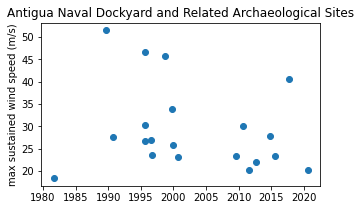

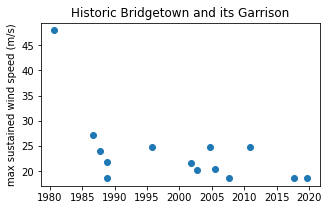

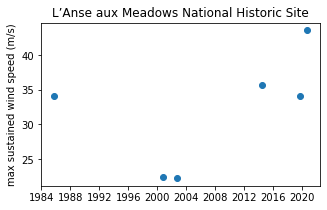

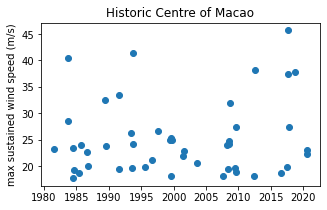

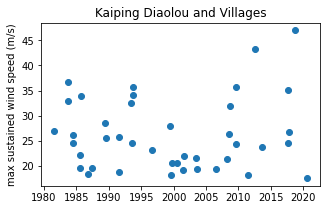

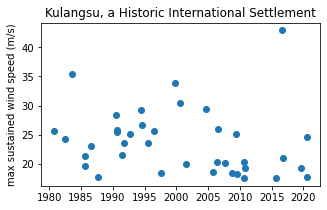

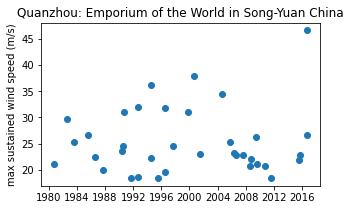

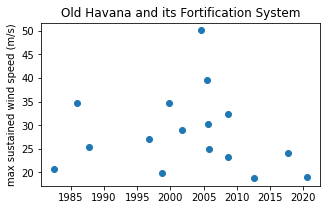

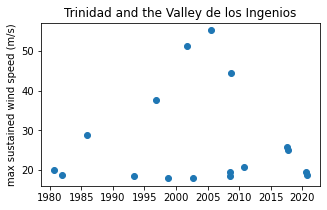

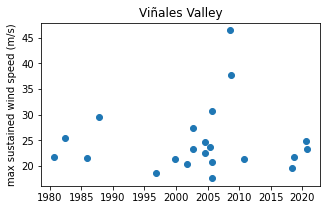

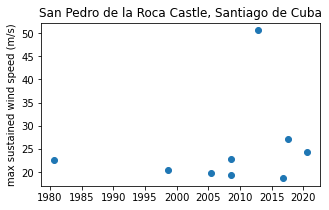

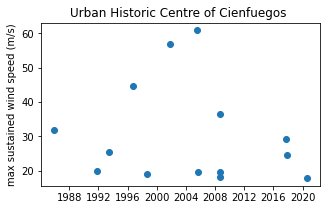

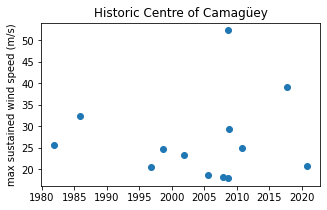

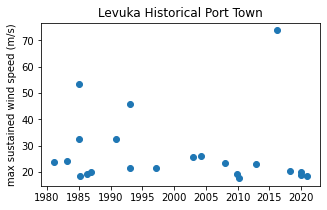

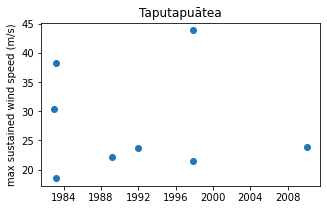

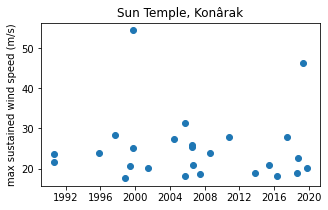

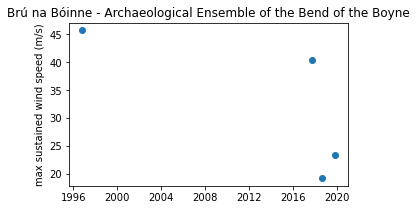

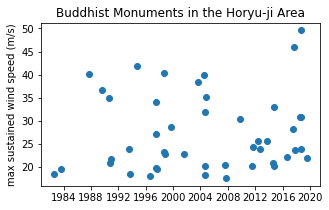

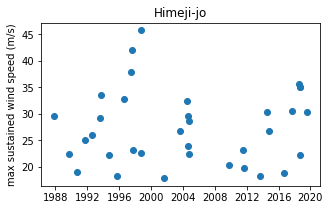

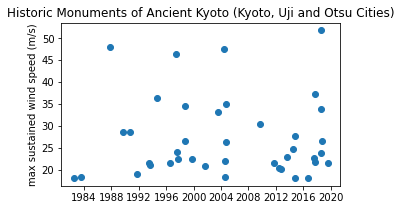

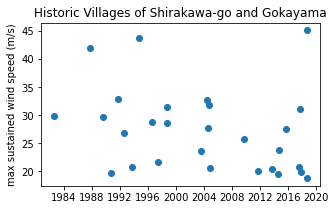

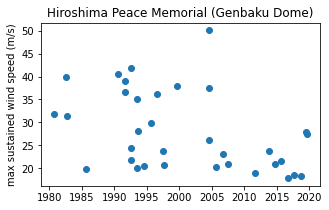

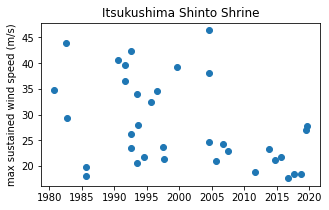

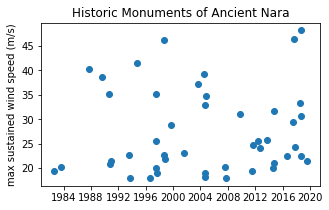

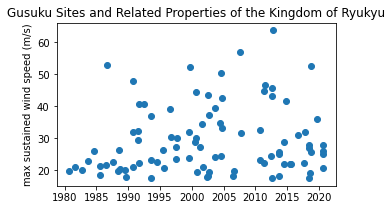

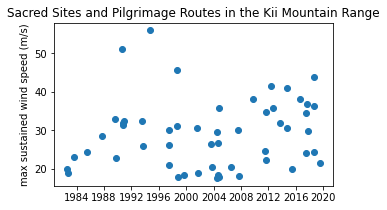

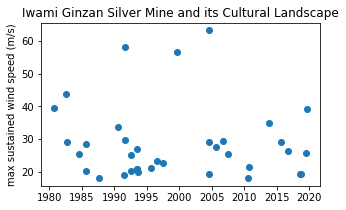

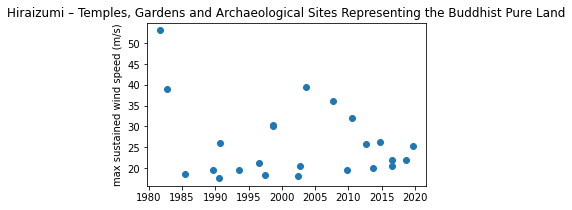

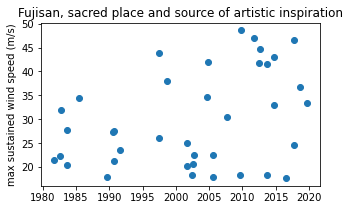

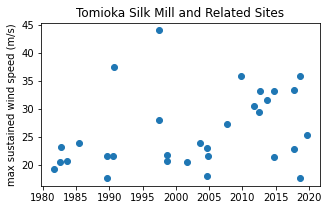

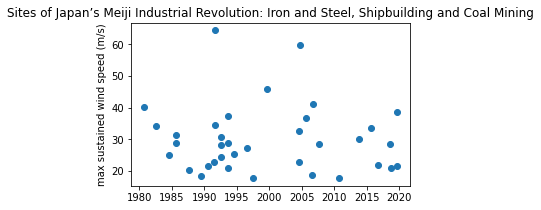

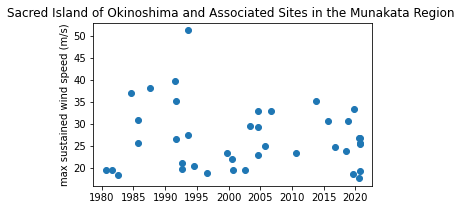

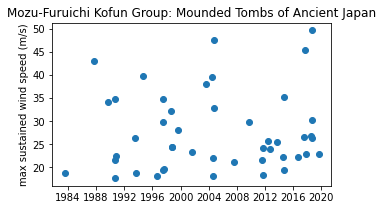

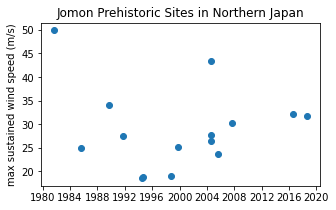

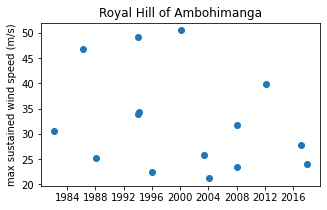

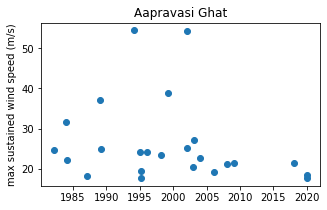

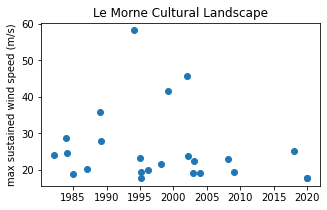

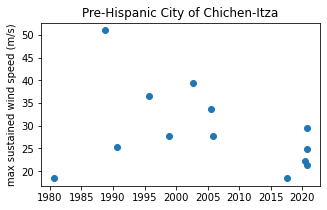

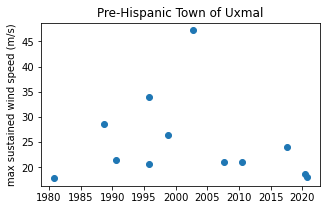

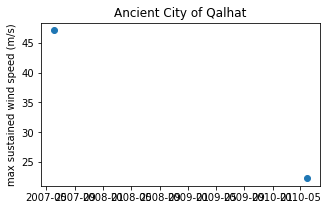

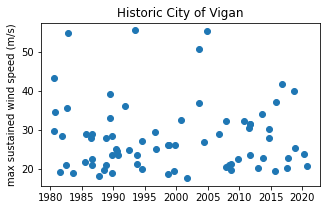

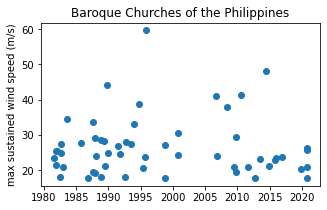

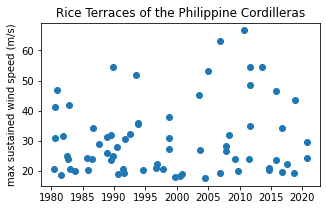

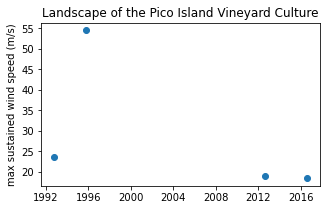

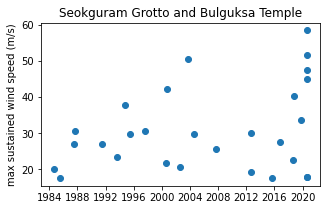

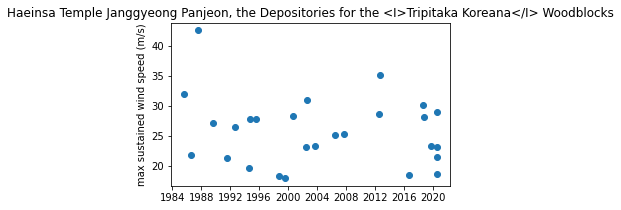

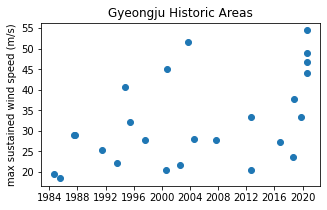

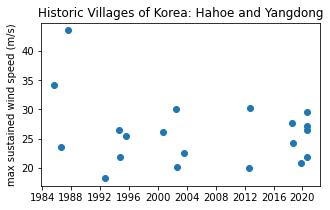

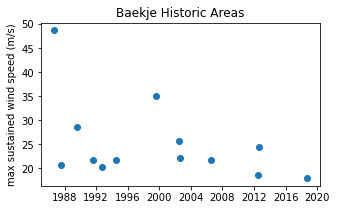

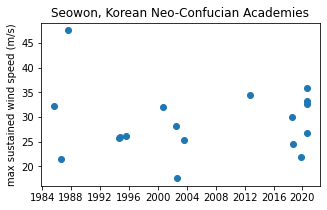

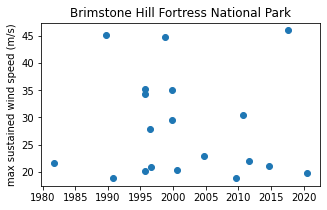

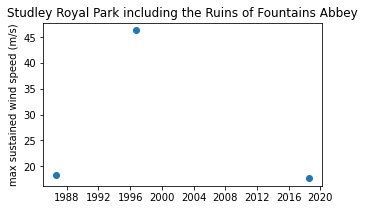

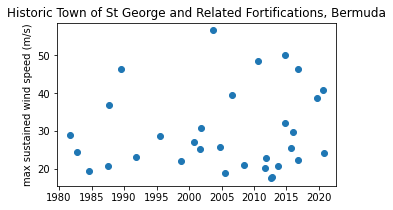

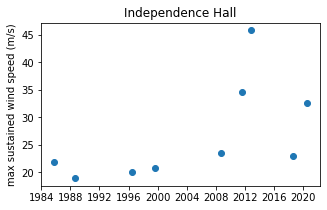

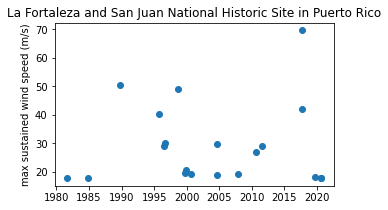

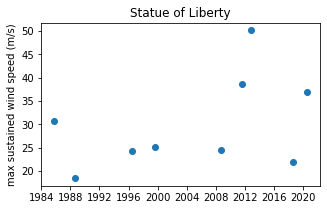

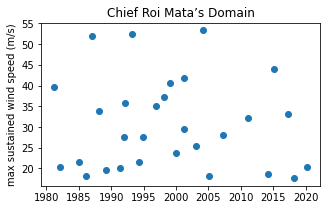

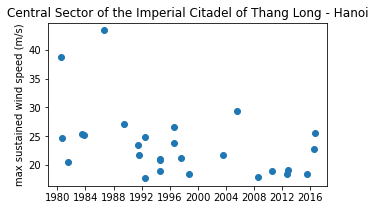

In [79]:
import datetime
sites = exposures.gdf[exposures.gdf['impact ratio tc']>0]

for site in sites.index:    
    centroid = sites.loc[site]['centr_TC']
    nonzero = tc_hist.intensity[:,centroid].nonzero()
    if tc_hist.intensity.nnz==0:
        continue
    intensity_site = tc_hist.intensity[nonzero[0],centroid]
    tc_date = tc_hist.date[nonzero[0]]
    tc_date = [datetime.date.fromordinal(date) for date in tc_date]

    fig,ax = plt.subplots(figsize=(5,3))
    ax.scatter(tc_date, intensity_site.toarray().flatten())
    ax.set_title(exposures.gdf.loc[site]['name_en'])
    ax.set_ylabel('max sustained wind speed (m/s)')
    if sites.loc[site]['name_en'] == 'Levuka Historical Port Town':
        fig.savefig('levuka_TC.pdf')


In [213]:
sites

,unique_number,id_no,rev_bis,name_en,name_fr,short_description_en,short_description_fr,justification_en,justification_fr,date_inscribed,...,udnp_code,transboundary,geometry,impf_TC,centr_TC,value,impf_RF,centr_RF,impact ratio flood,impact ratio tc
0,230.0,208.0,Rev,Cultural Landscape and Archaeological Remains ...,Paysage culturel et vestiges archéologiques de...,<p>The cultural landscape and archaeological r...,<p>Le paysage culturel et les vestiges archéol...,<p><em>Criterion (i):</em> The Buddha statues ...,<p><em>Critère (i):</em> Les statues de Bouddh...,2003.0,...,afg,0.0,POINT (67.82525 34.84694),1,10421,1,1,5170076,0.039101,0.0
1,234.0,211.0,Rev,Minaret and Archaeological Remains of Jam,Minaret et vestiges archéologiques de Djam,"<p>The 65m-tall Minaret of Jam is a graceful, ...","<p>Haut de 65m, le minaret de Djam est une con...",<p><em>Criterion (ii):</em> The innovative arc...,<p><em>Critère (ii)</em> : L'architecture et l...,2002.0,...,afg,0.0,POINT (64.51606 36.39656),1,-1,1,1,5026455,0.000000,0.0
2,1590.0,569.0,Bis,Historic Centres of Berat and Gjirokastra,Centres historiques de Berat et de Gjirokastra,<p>Berat and Gjirokastra are inscribed as rare...,<p>Berat et Gjirokastra sont inscrites en tant...,NaN,NaN,2005.0,...,alb,0.0,POINT (20.14083 40.07417),1,2754917,1,1,4684294,0.000000,0.0
3,1563.0,570.0,ter,Butrint,Butrint,"<p>Inhabited since prehistoric times, Butrint ...","<p>Habité depuis les temps préhistoriques, le ...",NaN,NaN,1992.0,...,alb,0.0,POINT (20.02095 39.74573),1,2768972,1,1,4716669,0.030621,0.0
4,111.0,102.0,NaN,Al Qal'a of Beni Hammad,La Kalâa des Béni Hammad,<p>In a mountainous site of extraordinary beau...,<p>Dans un site montagneux d&rsquo;une saisiss...,NaN,NaN,1980.0,...,dza,0.0,POINT (4.78684 35.81844),1,2919831,1,1,5077579,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1145,1503.0,1276.0,NaN,Rhaetian Railway in the Albula / Bernina Lands...,Chemin de fer rhétique dans les paysages de l’...,<p>Rhaetian Railway in the Albula / Bernina La...,<p>Le chemin de fer rh&eacute;tique dans le pa...,NaN,NaN,2008.0,...,"che,ita",1.0,POINT (9.84639 46.49833),1,2440681,1,1,4013802,0.000000,0.0
1148,1158.0,994.0,NaN,Curonian Spit,Isthme de Courlande,<p>Human habitation of this elongated sand dun...,<p>L'occupation humaine de cette étroite pénin...,<p><em>Criterion (v):</em> The Curonian Spit i...,<p><em>Critère (v) :</em> L’isthme de Courland...,2000.0,...,"ltu,rus",1.0,POINT (20.96239 55.27458),1,1941509,1,1,2922379,0.000000,0.0
1151,1894.0,1424.0,NaN,Wooden <em>Tserkvas</em> of the Carpathian Reg...,<em>Tserkvas</em> en bois de la région des Car...,<p>Situated in the eastern fringe of Central E...,<p>Situ&eacute; aux confins orientaux de l&rsq...,NaN,NaN,2013.0,...,"pol,ukr",1.0,POINT (21.03222 49.53389),1,2267600,1,1,3647052,0.000000,0.0
1152,1642.0,866.0,Bis,Prehistoric Rock Art Sites in the Côa Valley a...,Sites d’art rupestre préhistorique de la vallé...,<p>The two Prehistoric Rock Art Sites in the C...,<p>Les sites d'art rupestre préhistorique de l...,NaN,NaN,1998.0,...,"esp,prt",1.0,POINT (-6.66111 40.69750),1,2727531,1,1,4621972,0.000139,0.0


In [195]:
tc_date

array([723430, 726355, 726743, 728527, 728533, 728548, 728845, 728905,
       729647, 730044, 730071, 730351, 733651, 734008, 734370, 734735,
       735517, 735834, 736571, 737634])